# Optimal Scheduling of Dynamic transport
-- final project for 6.8300 in spring 2025  


### ODE based samplers

In [1]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2, 
                                              t_start + (t_end - t_start) / 2)  

### Training via flow-matching 

/home/zren/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


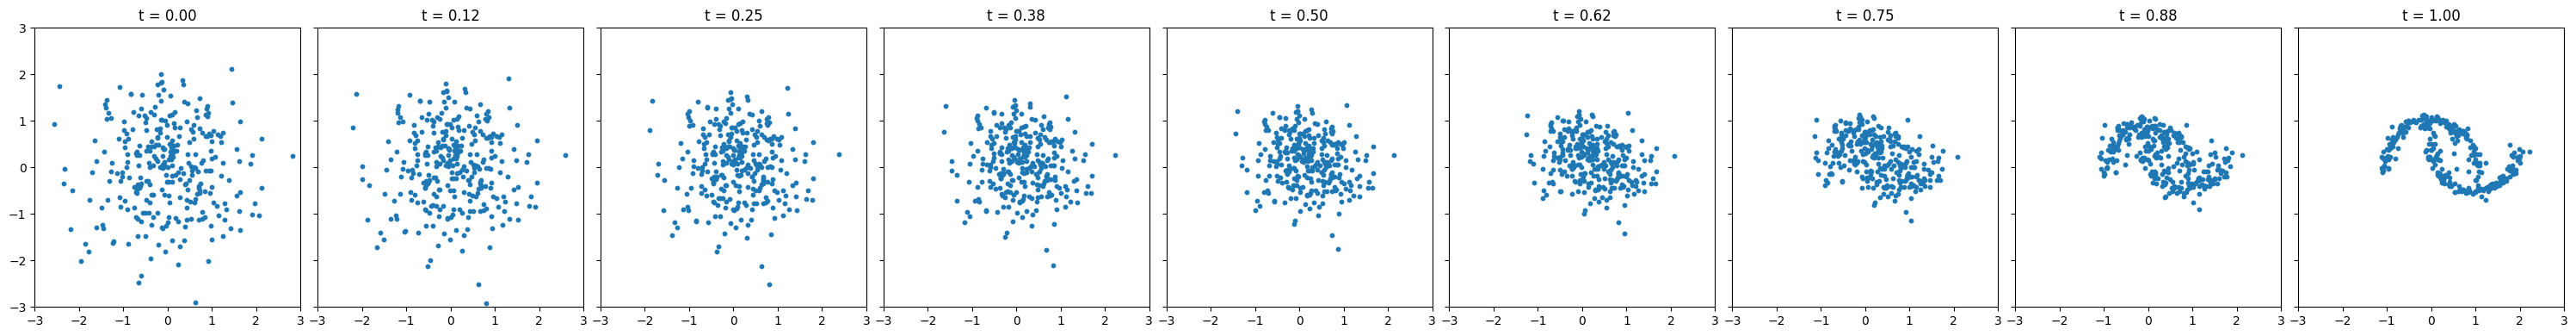

In [2]:
# example using 2d moon shape 
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()


In [26]:
# training a velocity field that pushes forward a diffuse 1d Gaussian to wide 1d Gaussian 
flow = Flow(dim = 1)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = torch.normal(mean=0, std = 0.1, size=(256,1))
    x_0 = torch.normal(mean=0, std = 10, size=(256,1))
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()


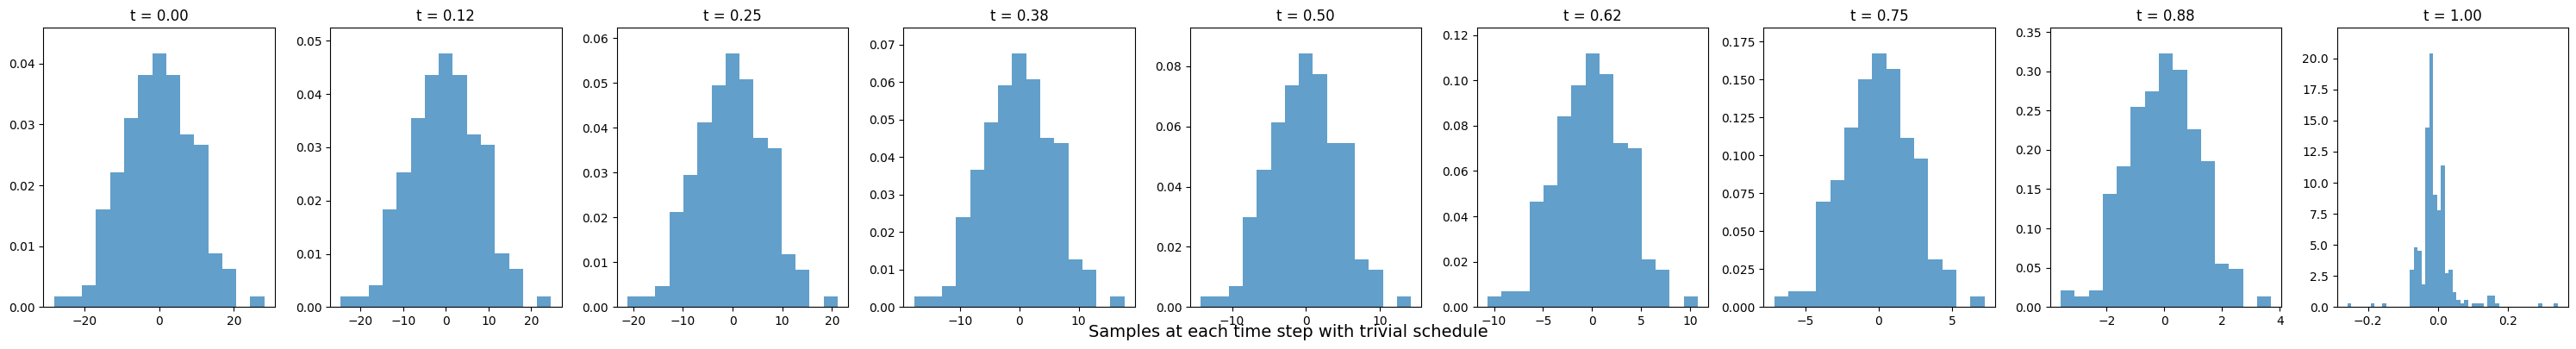

In [37]:
# plot of distributions under flow at each timestep 
import numpy as np 
M = 300
dim = 1
n_steps = 8

# 1) Sample initial particles as (M,1)
x = torch.normal(mean=0, std=10, size=(M, 1))

# 2) Set up the time grid
time_steps = torch.linspace(0.0, 1.0, n_steps + 1)

# 3) Prepare the figure (no shared x/y so each panel is independent)
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4))


# 4) Loop and plot each panel
for i in range(n_steps + 1):
    # for t>0, step forward
    if i > 0:
        t0 = time_steps[i-1]
        t1 = time_steps[i]
        x = flow.step(x, t0, t1)

    # pull out 1D numpy array
    data = x.detach().numpy().ravel()

    # compute "best" bin edges for this data
    bins = np.histogram_bin_edges(data, bins='auto')

    # plot histogram with its own bins
    counts, edges, patches = axes[i].hist(data, bins=bins, density=True, alpha=0.7)
    axes[i].set_title(f't = {time_steps[i]:.2f}')

    # set x‐limits to [min, max] with a small padding
    xmin, xmax = data.min(), data.max()
    pad = 0.05 * (xmax - xmin)
    axes[i].set_xlim(xmin - pad, xmax + pad)

    # set y‐limits just above the tallest bar
    axes[i].set_ylim(0, counts.max() * 1.1)
plt.subplots_adjust(bottom=0.5)   
fig.text(
    0.5,          # x‐position in figure coordinates (0=left, 1=right)
    0.0,         # y‐position in figure coordinates (0=bottom, 1=top)
    "Samples at each time step with trivial schedule",  # your title text
    ha="center",  # horizontal alignment
    va="bottom",  # vertical alignment
    fontsize=14
)

plt.tight_layout()
plt.show()

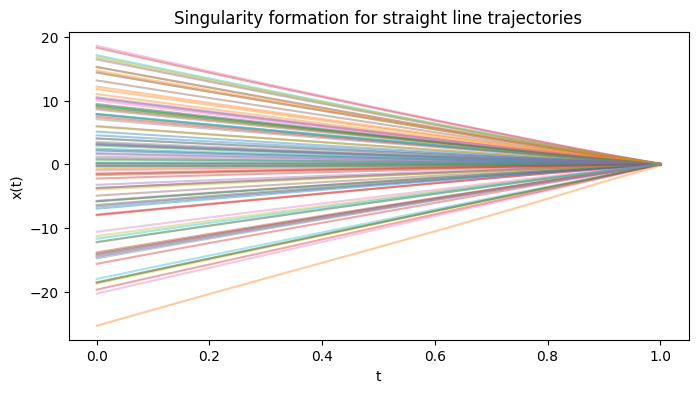

In [7]:
# Plot of trajectoris 

n_steps = 10

M, dim = 100, 1

# allocate trajectories [time, batch, dim]
traj = torch.zeros(n_steps+1, M, dim)

# sample initial particles
x0 = torch.normal(mean=0, std=10, size=(M, dim))
traj[0] = x0

# time grid
time_steps = torch.linspace(0, 1.0, n_steps+1)

# 2) Pass scalar t's into step:
for i in range(n_steps):
    t0 = time_steps[i]      # 0-dim Tensor
    t1 = time_steps[i+1]    # 0-dim Tensor

    traj[i+1] = flow.step(traj[i], t0, t1)

# plotting 1D trajectories over time
fig, ax = plt.subplots(figsize=(8,4))
for j in range(M):
    ax.plot(time_steps.detach().numpy(), traj[:, j, 0].detach().numpy(), alpha=0.4)
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("Singularity formation for straight line trajectories")
plt.show()

### Flow with optimal schedule (Univariate Gaussian distribution)


#### Analytical study 

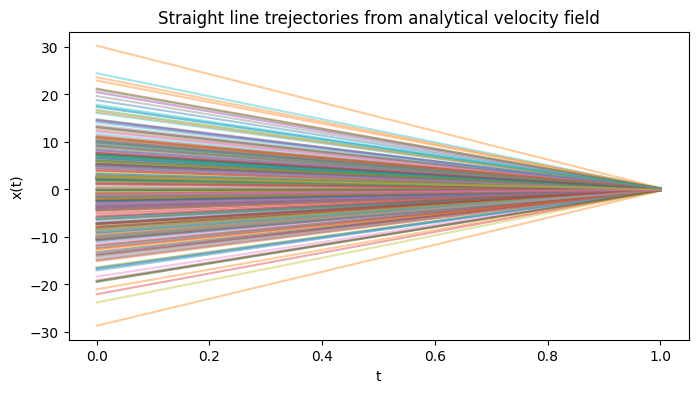

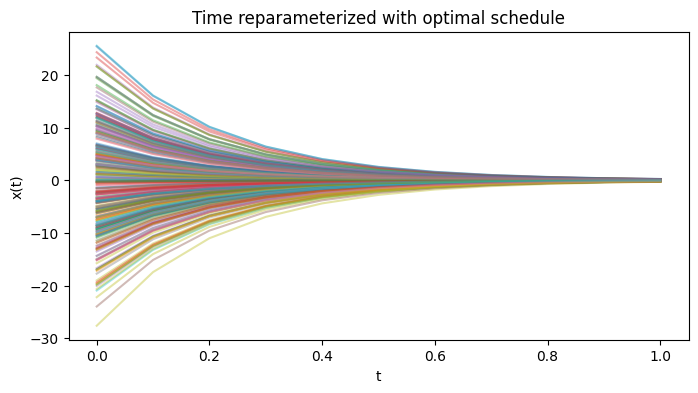

In [25]:
# Flow with Optimal schedule 

# Part 1: analytical computations 

# analytical expression for straight-line velocity field
from typing import Callable, Any

sigma_0 = 10
sigma_1 = 0.1 
def v_straight(x_t: Tensor, t: Tensor)->Tensor:
    """
    Straight-line velocity field
    :param x: (batch, dim)
    :param t: (batch, 1)
    :return: (batch, dim)
    """
    return (sigma_1/sigma_0 - 1) * x_t / ((1-t) + t * sigma_1 / sigma_0)


def tau_optimal(t):
    return ((sigma_1/sigma_0)**t - 1) / (sigma_1/sigma_0 - 1) 


# midpoint rule for integration 
def midpoint_update(v: Callable[..., Any], x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
    """
    Midpoint rule for integration
    :param x_t: (batch, dim)
    :param t_start: (batch, 1)
    :param t_end: (batch, 1)
    :return: (batch, dim)
    """
    # expand t_start to match the batch size of x_t

    t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
            
    return x_t + (t_end - t_start) * v(x_t + 
                                       v(x_t, t_start) * (t_end - t_start) / 2, t_start + (t_end - t_start) / 2)



def v_optimal(x_t: Tensor, t: Tensor) -> Tensor:
    """
    Optimal velocity field
    :param x: (batch, dim)
    :param t: (batch, 1)
    :return: (batch, dim)
    """
    return v_straight(x_t, tau_optimal(t))

# plot of trajectories 

x = torch.normal(mean=0, std=10, size=(M, dim))
n_steps = 10
traj = torch.zeros(n_steps+1, M, dim)
traj[0] = x
time_steps = torch.linspace(0, 1.0, n_steps+1)
for i in range(n_steps):
    t0 = time_steps[i]      # 0-dim Tensor
    t1 = time_steps[i+1]    # 0-dim Tensor

    traj[i+1] = midpoint_update(v_straight, traj[i], t0, t1)
# plotting 1D trajectories over time
fig, ax = plt.subplots(figsize=(8,4))
for j in range(M):
    ax.plot(time_steps.detach().numpy(), traj[:, j, 0].detach().numpy(), alpha=0.4)
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("Straight line trejectories from analytical velocity field")
plt.show()  

# substitution using optimal tau 

x = torch.normal(mean=0, std=10, size=(M, dim))
n_steps = 10
traj = torch.zeros(n_steps+1, M, dim)
traj[0] = x
time_steps = torch.linspace(0, 1.0, n_steps+1)
for i in range(n_steps):
    t0 = time_steps[i]      # 0-dim Tensor
    t1 = time_steps[i+1]    # 0-dim Tensor

    traj[i+1] = midpoint_update(v_straight, traj[i], tau_optimal(t0), tau_optimal(t1))
# plotting 1D trajectories over time
fig, ax = plt.subplots(figsize=(8,4))
for j in range(M):
    ax.plot(time_steps.detach().numpy(), traj[:, j, 0].detach().numpy(), alpha=0.4)
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("Time reparameterized with optimal schedule")
plt.show()  






t = 0.00, mean L ≈ 0.99
t = 0.10, mean L ≈ 1.10
t = 0.20, mean L ≈ 1.23
t = 0.30, mean L ≈ 1.41
t = 0.40, mean L ≈ 1.64
t = 0.50, mean L ≈ 1.96
t = 0.60, mean L ≈ 2.44
t = 0.70, mean L ≈ 3.22
t = 0.80, mean L ≈ 4.76
t = 0.90, mean L ≈ 9.08


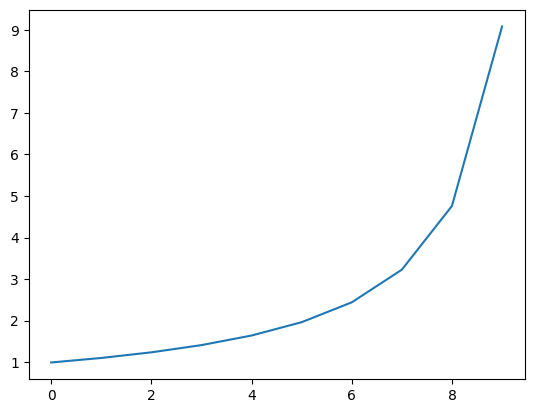

In [16]:
# compute Spatial Lipschitz constant of these velocity fields 
import torch.autograd.functional as F
def compute_lipschitz_constant(
    v: Callable[[Tensor,Tensor],Tensor],
    x_t: Tensor,
    t:   Tensor
) -> Tensor:
    """
    For each sample i, compute the spectral norm of J_i = D_x v(x_t[i], t[i]).
    :param v: function (x: (1,dim), t:(1,1)) -> (1,dim)
    :param x_t: (B,dim)
    :param t:   (B,1)
    :returns L: (B,) where L[i] = ||J_i||_2
    """
    B, dim = x_t.shape
    L = torch.zeros(B, device=x_t.device)

    for i in range(B):
        # isolate the i-th sample
        x_i = x_t[i:i+1].clone().detach().requires_grad_(True)  # (1,dim)
        t_i = t[i:i+1]                                           # (1,1)

        # define a scalar-output version of v so jacobian gives a (dim,dim) matrix
        def v_x(x):
            out = v(x, t_i)      # (1,dim)
            return out.squeeze(0)  # → (dim,)

        # compute the Jacobian J_i ∈ R^{dim×dim}
        J_i = F.jacobian(v_x, x_i).view(dim, dim)

        # spectral norm = largest singular value
        svals = torch.linalg.svdvals(J_i)
        L[i] = svals.max()

    return L.unsqueeze(1)  # return shape (B,1)

x = torch.normal(mean=0, std=10, size=(M, dim))

# pre-allocate trajectories
traj = torch.zeros(n_steps+1, M, dim)
traj[0] = x

time_steps = torch.linspace(0, 1.0, n_steps+1)

worst_Ls = []
for i in range(n_steps):
    t0 = time_steps[i]      # scalar tensor
    t1 = time_steps[i+1]    # scalar tensor

    # step forward
    traj[i+1] = midpoint_update(v_straight, traj[i], t0, t1)

    # **expand t0 to (M,1)** for compute_lipschitz_constant
    t0_batch = t0.view(1,1).expand(M,1)

    # compute L per sample
    L = compute_lipschitz_constant(v_straight, traj[i], t0_batch)

    print(f"t = {t0.item():.2f}, mean L ≈ {L.mean().item():.2f}")

    worst_Ls.append(L.abs().max().item())

plt.plot(worst_Ls)




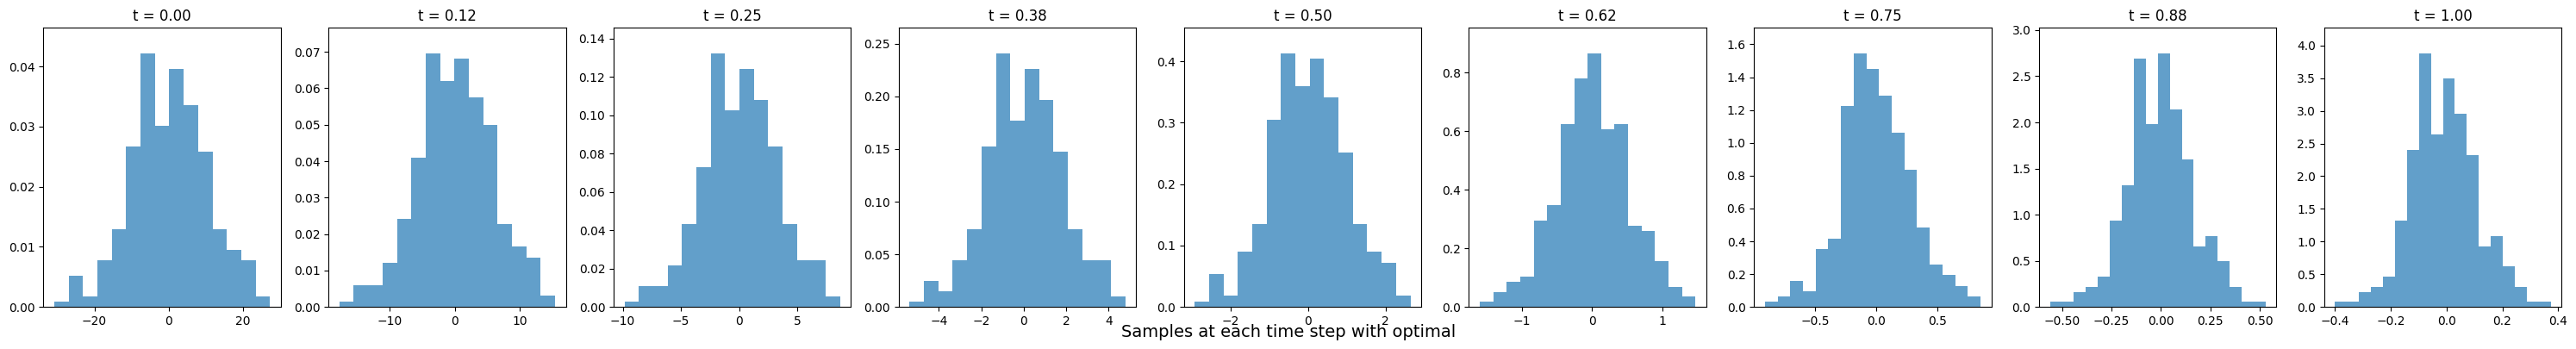

In [39]:
M = 300
dim = 1
n_steps = 8

# 1) Sample initial particles as (M,1)
x = torch.normal(mean=0, std=10, size=(M, 1))

# 2) Set up the time grid
time_steps = torch.linspace(0.0, 1.0, n_steps + 1)

# 3) Prepare the figure (no shared x/y so each panel is independent)
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4))

# 4) Loop and plot each panel
for i in range(n_steps + 1):
    # for t>0, step forward
    if i > 0:
        t0 = time_steps[i-1]
        t1 = time_steps[i]
        x = flow.step(x, tau_optimal(t0), tau_optimal(t1))

    # pull out 1D numpy array
    data = x.detach().numpy().ravel()

    # compute "best" bin edges for this data
    bins = np.histogram_bin_edges(data, bins='auto')

    # plot histogram with its own bins
    counts, edges, patches = axes[i].hist(data, bins=bins, density=True, alpha=0.7)
    axes[i].set_title(f't = {time_steps[i]:.2f}')

    # set x‐limits to [min, max] with a small padding
    xmin, xmax = data.min(), data.max()
    pad = 0.05 * (xmax - xmin)
    axes[i].set_xlim(xmin - pad, xmax + pad)

    # set y‐limits just above the tallest bar
    axes[i].set_ylim(0, counts.max() * 1.1)
plt.subplots_adjust(bottom=0.5)   
fig.text(
    0.5,          # x‐position in figure coordinates (0=left, 1=right)
    0.0,         # y‐position in figure coordinates (0=bottom, 1=top)
    "Samples at each time step with optimal",  # your title text
    ha="center",  # horizontal alignment
    va="bottom",  # vertical alignment
    fontsize=14
)
plt.tight_layout()
plt.show()

#### Learning With optimal schedule 

In [9]:
# Flow with optimal schedule

# Incoorporate the optimal schedule into the learning scheme 
# Recall the optimal schedule can be described by a 4-parameter family 

# define a time reparameterized NN class 




class Flow_optimal(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
        init = torch.log(torch.tensor([0.8, 1.0, 1.0, 0.3]))
        self.tau_params = nn.Parameter(init)  # [log f_l, log f_u, log g_l, log g_u]

    def tau(self, t: Tensor) -> Tensor:
        """
        Numerically stable piecewise τ(t).  t: (batch,1) in [0,1].
        """
        # unpack >0
        f_l, f_u, g_l, g_u = torch.exp(self.tau_params)

        eps = 1e-6

        # safe ratio = g_l/f_u in (eps, 1-eps)
        ratio = (g_l / f_u).clamp(min=eps, max=1-eps)

        # base1 = 2 - f_u/g_l - g_l/f_u, clamp >= eps
        base1 = (2 - f_u/g_l - g_l/f_u).clamp(min=eps)

        # base2 = 2*(g_l+1)/(1 - ratio), clamp >= eps
        denom2 = (1 - ratio).clamp(min=eps)
        base2  = (2*(g_l+1) / denom2).clamp(min=eps)

        # branch1: (1/f_u) * [ (1/(4*(g_l+1))) * base1^t  - 1/f_u ]
        coef1 = 1.0/(4*(g_l + 1))
        term1 = (1/f_u) * ( coef1 * torch.pow(base1, t) - 1/f_u )

        # branch2: 0.5*(1/f_u - 1/g_l)*[ base2^t * ((1-ratio)/2)^(1-t) ] - 1/g_l
        coef2 = 0.5*(1/f_u - 1/g_l)
        j = ((1 - ratio)/2).clamp(min=eps)                      # clamp (1-ratio)/2 >= eps
        term2 = coef2 * torch.pow(base2, t) * torch.pow(j, (1-t)) - 1/g_l

        # mask for t <= 0.5
        mask = (t <= 0.5).to(t.dtype)

        return mask*term1 + (1-mask)*term2
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        tau_t = self.tau(t)
        inp   = torch.cat((tau_t, x_t), dim=-1)
        return self.net(inp)
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2, 
                                              t_start + (t_end - t_start) / 2)  











In [10]:
# training with time-reparameterization 
flow_opt = Flow_optimal(dim=1)

opt = torch.optim.Adam(flow_opt.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for _ in range(10000):
    # 1) sample endpoints and t
    x0 = torch.normal(0,sigma_0,size=(256,dim))
    x1 = torch.normal(0,sigma_1,size=(256,dim))
    t  = torch.rand(256,1, requires_grad=True)  # we need grad for τ′

    # 2) compute τ and x_t
    tau_t = flow_opt.tau(t)                                
    x_t   = (1 - tau_t)*x0 + tau_t*x1                  


    # 4) define the velocity target
    dx_target = (x1 - x0)                  

    # 5) predict and compute loss
    v_pred = flow_opt(x_t, tau_t)                               # v(x_t, t)
    loss   = loss_fn(v_pred, dx_target)

    # 6) backward and step
    opt.zero_grad()
    loss.backward()
    opt.step()


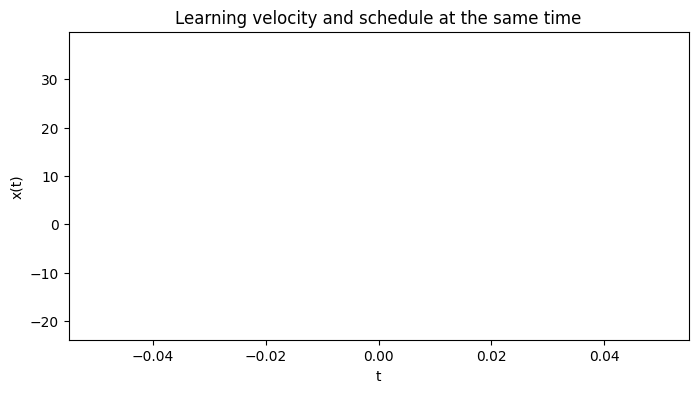

In [110]:
n_steps = 10
M, dim = 100, 1

# 1) Sample initial particles and store them
x = torch.normal(mean=0, std=10, size=(M,dim))  # shape (M,1)
traj = torch.zeros(n_steps+1, M, dim)
traj[0] = x

# 2) Time grid
time_steps = torch.linspace(0, 1.0, n_steps+1)

# 3) March forward, updating 'x' each step
for i in range(n_steps):
    t0 = time_steps[i]      # scalar tensor
    t1 = time_steps[i+1]    # scalar tensor

    # update x in place
    x = flow_opt.step(x, t0, t1)  
    traj[i+1] = x            # record it

# 4) Plot the nonzero trajectories

fig, ax = plt.subplots(figsize=(8,4))
for j in range(M):
    ax.plot(time_steps.numpy(),
            traj[:, j, 0].detach().numpy(),
            alpha=0.4)
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("Learning velocity and schedule at the same time")
plt.show()

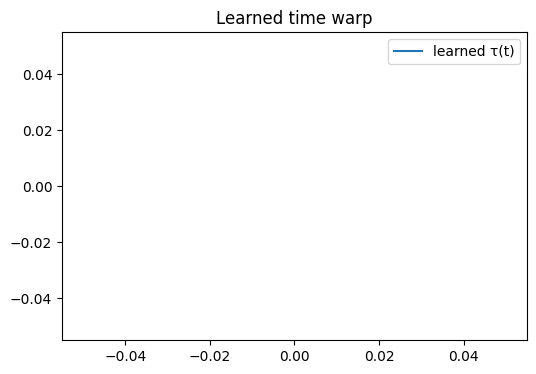

In [115]:
tt = torch.linspace(0,1,200).unsqueeze(1)
with torch.no_grad():
    τ_vals = flow_opt.tau(tt).detach().numpy()

plt.figure(figsize=(6,4))
plt.plot(tt.numpy(), τ_vals, label="learned τ(t)")
# plt.plot([0,1],[0,1],"--",label="identity")
# plt.xlabel("t"); plt.ylabel("τ(t)")
plt.legend(); plt.title("Learned time warp")
plt.show()

Step  500  Loss 1.1813e+01
Step 1000  Loss 7.3312e+00
Step 1500  Loss 4.1546e+00
Step 2000  Loss 3.2147e+00
Step 2500  Loss 2.2976e+00
Step 3000  Loss 9.1706e-01
Step 3500  Loss 1.4546e+00
Step 4000  Loss 9.7792e-01
Step 4500  Loss 8.4190e-01
Step 5000  Loss 2.1454e+00


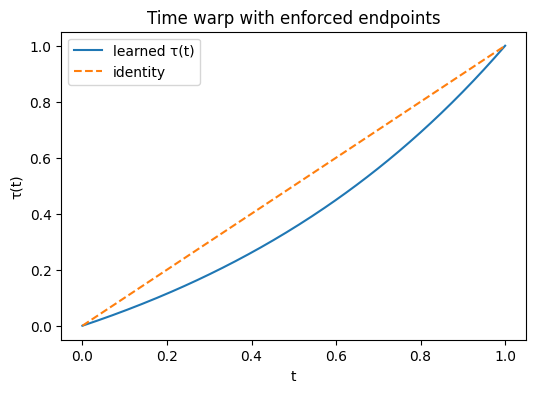

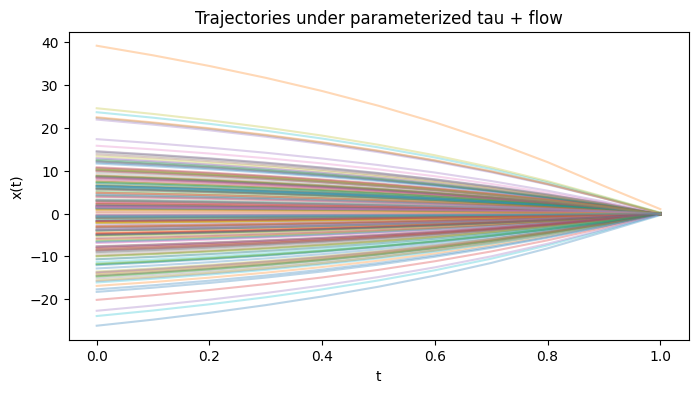

In [143]:
class FlowOptimalNNTau(nn.Module):
    def __init__(self, dim: int = 1, h: int = 64, tau_h: int = 32):
        super().__init__()
        # h(t): the unconstrained “bump” network
        # self.h_net = nn.Sequential(
        #     nn.Linear(1, tau_h), nn.ELU(),
        #     nn.Linear(tau_h, tau_h), nn.ELU(),
        #     nn.Linear(tau_h, 1)
        # )
        # g(x,τ): the vector‐field wrt τ
        self.g_net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h),       nn.ELU(),
            nn.Linear(h, dim)
        )
        self.tau_param = nn.Parameter(torch.tensor([-1.0]))
        

    def tau(self, t: Tensor) -> Tensor:
        """
        Enforce τ(0)=0, τ(1)=1 via τ(t)=t + t*(1-t)*h(t).
        t: shape (batch,1) in [0,1]
        returns: same shape, always in [0,1] if h small
        """
        # bump = self.h_net(t)                # unconstrained
        # return t + t * (1 - t) * bump       # vanishes at t=0,1

        return (torch.exp(self.tau_param) ** t - 1) / (torch.exp(self.tau_param) - 1) 

    def forward(self, x_t: Tensor, tau_t: Tensor) -> Tensor:
        """
        Predict dx/dτ = g(x_t, tau_t)
        """
        inp = torch.cat([x_t, tau_t], dim=-1)
        return self.g_net(inp)

    def step(self, x_t: Tensor, t0: Tensor, t1: Tensor) -> Tensor:
        """
        Midpoint step in real time t:
          dx/dt = g(x, τ(t)) * dτ/dt
        Approximate dτ/dt by (τ1−τ0)/(t1−t0).
        """
        batch = x_t.shape[0]
        t0b = t0.view(1,1).expand(batch,1)
        t1b = t1.view(1,1).expand(batch,1)

        τ0 = self.tau(t0b)
        τ1 = self.tau(t1b)
        τm = self.tau((t0b + t1b)/2)

        dt    = t1b - t0b
        dτdt  = (τ1 - τ0) / dt

        h0 = self.forward(x_t,    τ0)
        xm = x_t + h0 * (τm - τ0)
        h1 = self.forward(xm,     τm)

        # combine: dx = (dx/dτ)*(dτ/dt)*dt
        return x_t + h1 * dτdt * dt

# ---------------------------------------------------------------------------- #
# 2) Training
# ---------------------------------------------------------------------------- #
dim      = 1
sigma_0  = 10.0
sigma_1  = 0.1
batch    = 256
lr       = 1e-3
n_steps  = 5000

flow = FlowOptimalNNTau(dim=dim, h=64, tau_h=32)
opt  = torch.optim.Adam(flow.parameters(), lr=lr)
mse  = nn.MSELoss()

for step in range(1, n_steps+1):
    x0 = torch.normal(0, sigma_0, size=(batch,dim))
    x1 = torch.normal(0, sigma_1, size=(batch,dim))
    t  = torch.rand(batch,1)

    τ_t = flow.tau(t)
    x_t = (1 - τ_t)*x0 + τ_t*x1

    target = x1 - x0
    pred   = flow(x_t, τ_t)
    loss   = mse(pred, target)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 500 == 0:
        print(f"Step {step:4d}  Loss {loss.item():.4e}")

# ---------------------------------------------------------------------------- #
# 3) Plot learned τ
# ---------------------------------------------------------------------------- #
tt = torch.linspace(0,1,200).unsqueeze(1)
with torch.no_grad():
    τ_vals = flow.tau(tt).cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(tt.numpy(),    τ_vals,      label="learned τ(t)")
plt.plot([0,1],[0,1],  "--",         label="identity")
plt.xlabel("t"); plt.ylabel("τ(t)")
plt.legend(); plt.title("Time warp with enforced endpoints")
plt.show()

# ---------------------------------------------------------------------------- #
# 4) Sample trajectories
# ---------------------------------------------------------------------------- #
n_steps_samp = 10
time_steps   = torch.linspace(0,1,n_steps_samp+1)
M            = 200
particles    = torch.normal(0, sigma_0, size=(M,dim))

fig, ax = plt.subplots(figsize=(8,4))
for j in range(M):
    x = particles[j].view(1,dim)
    traj = [x.item()]
    for i in range(n_steps_samp):
        t0 = time_steps[i]
        t1 = time_steps[i+1]
        x  = flow.step(x, t0, t1)
        traj.append(x.item())
    ax.plot(time_steps.numpy(), traj, alpha=0.3)

ax.set_xlabel("t"); ax.set_ylabel("x(t)")
ax.set_title("Trajectories under parameterized tau + flow")
plt.show()

In [137]:
flow.tau_param

Parameter containing:
tensor([3.7571], requires_grad=True)

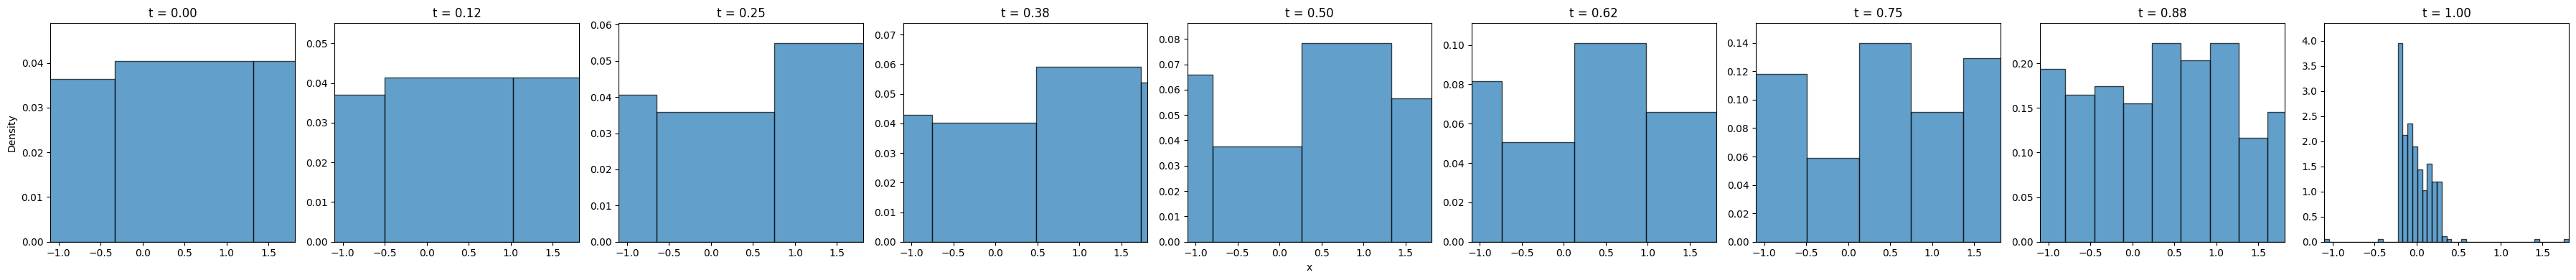

In [140]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------------------- #
# Assumes you have:
#   flow        = trained FlowOptimalNNTau instance
#   sigma_0     = initial standard deviation (e.g. 10.0)
# ---------------------------------------------------------------------------- #

# Parameters
n_samples = 300   # number of particles
dim       = 1
n_steps   = 8     # number of histogram panels
sigma_0   = 10.0  # must match your training

# Sample initial particles from N(0, sigma_0^2)
x_t = torch.normal(0, sigma_0, size=(n_samples, dim))

# Time grid
time_steps = torch.linspace(0.0, 1.0, n_steps + 1)

# Prepare figure (no sharey so each panel can autoscale y)
fig, axes = plt.subplots(1, n_steps + 1, figsize=(4*(n_steps+1), 4),
                         sharex=True, sharey=False)

for i, t in enumerate(time_steps):
    if i > 0:
        # advance particles from t_{i-1} to t_i
        t0 = time_steps[i-1]
        t1 = t
        x_t = flow.step(x_t, t0, t1)

    data = x_t.detach().numpy().ravel()

    # compute histogram manually to get counts for y-limits
    counts, bins = np.histogram(data, bins=50, density=True)

    # plot histogram with same bin edges
    axes[i].hist(data, bins=bins, density=True, alpha=0.7, edgecolor='black')
    axes[i].set_title(f"t = {t:.2f}")

    # rescale y-axis to this histogram's max
    axes[i].set_ylim(0, counts.max() * 1.1)

    # optional: fix x-limits so you still see full support
    axes[i].set_xlim(data.min(), data.max())

# axis labels
axes[0].set_ylabel("Density")
axes[n_steps//2].set_xlabel("x")

plt.tight_layout()
plt.show()

In [167]:
# iterative solver 
from torch import autograd
import torch.autograd.functional as F
class TriangularLinear(nn.Module):
    def __init__(self, size: int, lower: bool = True, bias: bool = True):
        """
        A (size × size) Linear layer whose weight is masked to be
        lower-triangular (if lower=True) or upper-triangular otherwise.
        """
        super().__init__()
        self.linear = nn.Linear(size, size, bias=bias)
        # build the binary mask once
        mask = torch.tril(torch.ones(size, size)) if lower else torch.triu(torch.ones(size, size))
        self.register_buffer('mask', mask)

    def forward(self, x: Tensor) -> Tensor:
        # mask off the weight
        w = self.linear.weight * self.mask
        return F.linear(x, w, self.linear.bias)

# ---------------------------------------------------------------------------- #
# 2) A Flow class with triangular hidden layers
# ---------------------------------------------------------------------------- #
class FlowTriangular(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        # input→first hidden: full
        layers = [ nn.Linear(dim+1, h), nn.ELU() ]
        # two triangular hidden→hidden
        layers += [
            TriangularLinear(h, lower=True), nn.ELU(),
            TriangularLinear(h, lower=True), nn.ELU(),
        ]
        # final hidden→output: full
        layers += [ nn.Linear(h, dim) ]
        self.g_net = nn.Sequential(*layers)

    def forward(self, x_t: Tensor, tau_t: Tensor) -> Tensor:
        """
        x_t: (batch, dim)
        tau_t: (batch, 1)
        returns: (batch, dim)  = dx / dτ
        """
        inp = torch.cat([x_t, tau_t], dim=-1)  # → (batch, dim+1)
        return self.g_net(inp)

    def step(self, x_t: Tensor, t0: Tensor, t1: Tensor, tau_fn) -> Tensor:
        """
        Same midpoint‐in‐t step as before; unchanged.
        """
        B = x_t.shape[0]
        t0b = t0.view(1,1).expand(B,1)
        t1b = t1.view(1,1).expand(B,1)

        τ0 = tau_fn(t0b)
        τ1 = tau_fn(t1b)
        τm = tau_fn((t0b+t1b)/2)

        dt   = t1b - t0b
        dτdt = (τ1 - τ0)/dt

        h0  = self.forward(x_t,   τ0)
        xm  = x_t + h0 * (τm - τ0)
        h1  = self.forward(xm,    τm)

        return x_t + h1 * dτdt * dt
# ---------------------------------------------------------------------------- #
# 2) Spectral‐radius estimator
# ---------------------------------------------------------------------------- #
def estimate_endpoint_spectral(flow, x0: Tensor, t_grid: Tensor, tau_fn):
    """
    True 1D endpoint Jacobian via chaining:
      J ≈ ∏_i [1 + (df/dx)(x_i,τ_i) * (τ(t_{i+1})-τ(t_i))]
    Args:
      flow    : Flow instance with forward(x,τ)=dx/dτ
      x0      : (B,1) initial points
      t_grid  : (N+1,1) uniform times from 0 to 1
      tau_fn  : function mapping (batch,1) t→τ
    Returns:
      Js      : (B,) endpoint Jacobians
      Jmax,Jmin: floats
    """
    B = x0.shape[0]
    device = x0.device

    # initialize
    x = x0.clone().to(device)   # (B,1)
    Js = torch.ones(B, device=device)

    # loop intervals
    for i in range(len(t_grid)-1):
        t0 = t_grid[i].view(1,1)
        t1 = t_grid[i+1].view(1,1)

        # compute Δτ
        τ0 = tau_fn(t0).expand(B,1)
        τ1 = tau_fn(t1).expand(B,1)
        delta_tau = (τ1 - τ0).view(-1)   # (B,)

        # step each particle and compute df/dx by jacobian
        new_x = []
        for k in range(B):
            xk = x[k].view(1,1)
            τk = τ0[k].view(1,1)

            # df/dx at (xk,τk)
            def g_scalar(x_in: Tensor) -> Tensor:
                return flow.forward(x_in, τk)  # returns (1,1)
            # jac returns shape (1,1,1,1) so squeeze twice
            jac = F.jacobian(g_scalar, xk).squeeze().item()

            # multiply local factor
            Js[k] *= abs(1 + jac * delta_tau[k].item())

            # advance state
            xk_next = flow.step(xk, t0, t1, tau_fn)
            new_x.append(xk_next.detach())

        x = torch.cat(new_x, dim=0)

    return Js, float(Js.max()), float(Js.min())
# ---------------------------------------------------------------------------- #
# 3) Your update_tau rule
# ---------------------------------------------------------------------------- #
def update_tau(t: Tensor, lmax: float, lmin: float) -> Tensor:
    """
    τ(t) = (1 + max(|lmin|, lmax))^t / max(|lmin|, lmax)
    """
    max_lam = max(lmax, abs(lmin))
    return torch.pow(1.0 + max_lam, t) / max_lam


--- Outer iteration 0 ---
Flow‐fit loss: 1.787e+01
True endpoint spectral radii: lmax=0.401, lmin=0.028

--- Outer iteration 1 ---
Flow‐fit loss: 2.411e+00
True endpoint spectral radii: lmax=2.233, lmin=1.514

--- Outer iteration 2 ---
Flow‐fit loss: 9.753e+01
True endpoint spectral radii: lmax=1.145, lmin=0.431

--- Outer iteration 3 ---
Flow‐fit loss: 5.908e+01
True endpoint spectral radii: lmax=5.140, lmin=1.837

--- Outer iteration 4 ---
Flow‐fit loss: 4.401e+01
True endpoint spectral radii: lmax=0.953, lmin=0.156

--- Outer iteration 5 ---
Flow‐fit loss: 5.353e+01
True endpoint spectral radii: lmax=2.904, lmin=1.381

--- Outer iteration 6 ---
Flow‐fit loss: 9.985e+01
True endpoint spectral radii: lmax=1.067, lmin=0.633

--- Outer iteration 7 ---
Flow‐fit loss: 5.093e+01
True endpoint spectral radii: lmax=3.374, lmin=1.486

--- Outer iteration 8 ---
Flow‐fit loss: 6.549e+01
True endpoint spectral radii: lmax=0.990, lmin=0.348

--- Outer iteration 9 ---
Flow‐fit loss: 3.048e+01
Tru

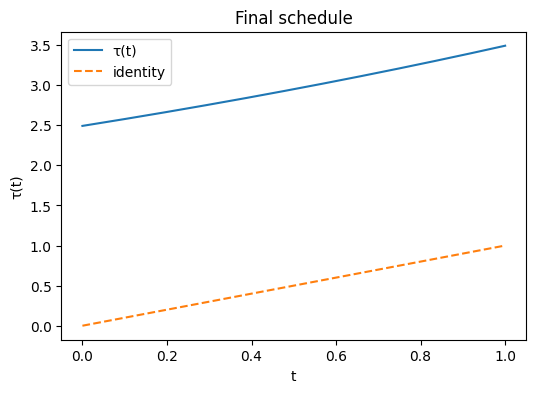

In [168]:
dim         = 1
sigma_0     = 10.0
sigma_1     = 0.1
batch       = 256
lr          = 1e-3
flow_epochs = 100    # train flow this many batches per outer iter
outer_iters = 100
n_grid      = 100    # for spectral estimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flow   = Flow(dim=dim, h=64).to(device)
opt    = torch.optim.Adam(flow.parameters(), lr=lr)
mse    = nn.MSELoss()

# initialize schedule to identity
lmax, lmin = 0.0, 0.0
tau_fn = lambda t: t  # initially τ(t)=t

for k in range(outer_iters):
    print(f"\n--- Outer iteration {k} ---")

    # 1) Fit flow for current tau_fn
    for ep in range(flow_epochs):
        x0 = torch.normal(0, sigma_0, (batch,dim), device=device)
        x1 = torch.normal(0, sigma_1, (batch,dim), device=device)
        t  = torch.rand(batch,1, device=device)

        with torch.no_grad():
            τ   = tau_fn(t)               # (batch,1)
            x_t = (1-τ)*x0 + τ*x1

        target = x1 - x0
        pred   = flow(x_t, τ)
        loss   = mse(pred, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"Flow‐fit loss: {loss.item():.3e}")

    # 2) Estimate spectral radii on grid
    with torch.no_grad():
        n_grid = 100
        x0g = torch.normal(0, sigma_0, (n_grid,1), device=device)

        # 2) build a uniform t_grid from 0 to 1
        t_grid = torch.linspace(0,1,n_grid+1,device=device).unsqueeze(1)

        # 3) estimate the true endpoint Jacobians
        Js, lmax, lmin = estimate_endpoint_spectral(flow, x0g, t_grid, tau_fn)

        print(f"True endpoint spectral radii: lmax={lmax:.3f}, lmin={lmin:.3f}")

# 4) now update your tau for the next iteration
        tau_fn = lambda t, lmax=lmax, lmin=lmin: update_tau(t, lmax, lmin)

# Final plot of learned tau
tt = torch.linspace(0,1,200,device=device).unsqueeze(1)
with torch.no_grad():
    tau_vals = tau_fn(tt).cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(tt.cpu(), tau_vals, label="τ(t)")
plt.plot([0,1],[0,1],"--",label="identity")
plt.xlabel("t"); plt.ylabel("τ(t)")
plt.legend(); plt.title("Final schedule")
plt.show()



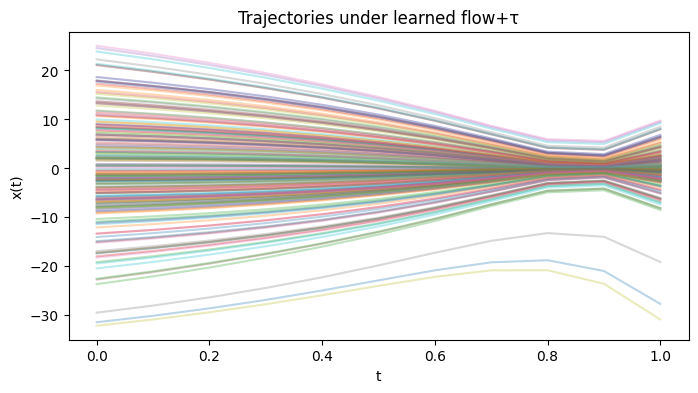

In [166]:
# Sample and plot trajectories
n_steps = 10
time_steps = torch.linspace(0,1,n_steps+1).to(device)
M = 200
particles = torch.normal(0, sigma_0, (M,dim), device=device)

fig, ax = plt.subplots(figsize=(8,4))
for j in range(M):
    x = particles[j].view(1,dim)
    traj = [x.item()]
    for i in range(n_steps):
        t0 = time_steps[i].view(1,1)
        t1 = time_steps[i+1].view(1,1)
        x  = flow.step(x, t0, t1, tau_fn)
        traj.append(x.item())
    ax.plot(time_steps.cpu(), traj, alpha=0.3)

ax.set_xlabel("t"); ax.set_ylabel("x(t)")
ax.set_title("Trajectories under learned flow+τ")
plt.show()